# Image Umap

This notebook loads a csv and builds a Umap visualisation around one metadata column

### Import Variables

In [59]:
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np
from PIL import Image
from sklearn.feature_extraction import image
from skimage import io
from sklearn.manifold import TSNE
from tqdm import tqdm

### Parse all images in custom folder, saves their color and path into the data array

See: `save_wikidata_images.ipynb` to create a folder containing images from Wikidata.

In [61]:
data = []
folder = '../assets/wikidata_crop/'

for filename in tqdm((os.listdir(folder))):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (100,100))
        image = image.flatten()
        data.append([image, folder + filename])

100%|████████████████████████████████████████| 483/483 [00:00<00:00, 650.46it/s]


### Training

In [266]:
features, images  = zip(*data)

In [73]:
from sklearn.decomposition import PCA

features = np.array(data)
pca = PCA(n_components = 10)
pca.fit(features)
pca_features = pca.transform(features)

In [74]:
import umap.umap_ as umap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP(
        n_neighbors = 7,
        min_dist = 1
)

X = np.array(pca_features)
pipe = Pipeline([('scaling', StandardScaler()), ('umap', reducer)])
embedding = pipe.fit_transform(X)

In [75]:
len(embedding[0]), len(images)

(2, 483)

In [76]:
tx, ty = embedding[:,0], embedding[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Plots the clusters

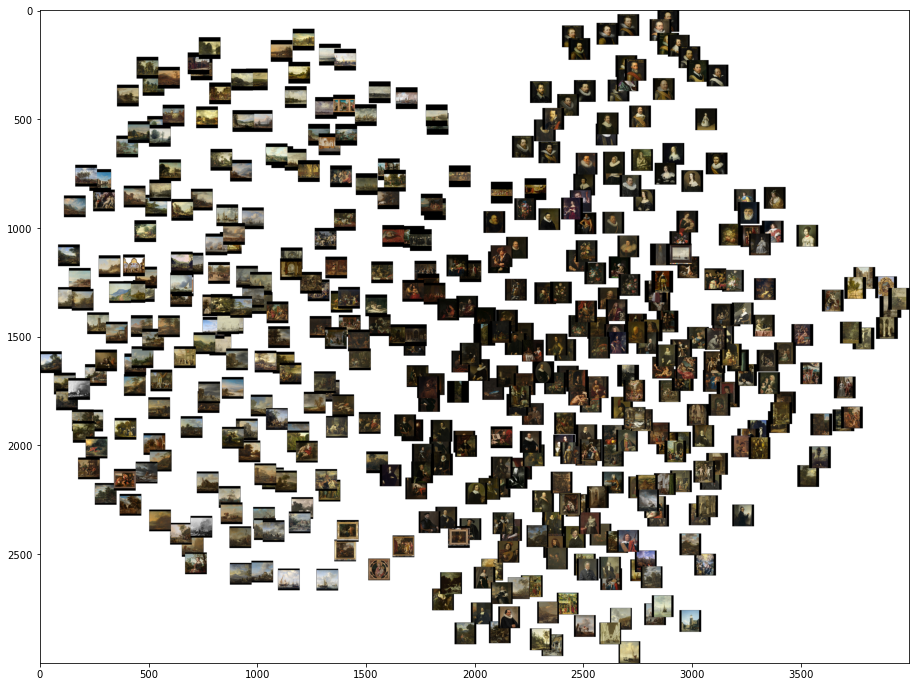

In [77]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

### Save a json and a png of the cluster

In [54]:
import os
import json

full_image.save("../data/test_UMAP.png")
umap_path = "../data/test_UMAP.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(umap_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved UMAP result to %s" % umap_path)


saved UMAP result to ../data/test_UMAP.json


### Paste into grid

In [78]:
import rasterfairy
nx = 20
ny = 20

grid_assignment = rasterfairy.transformPointCloud2D(embedding)

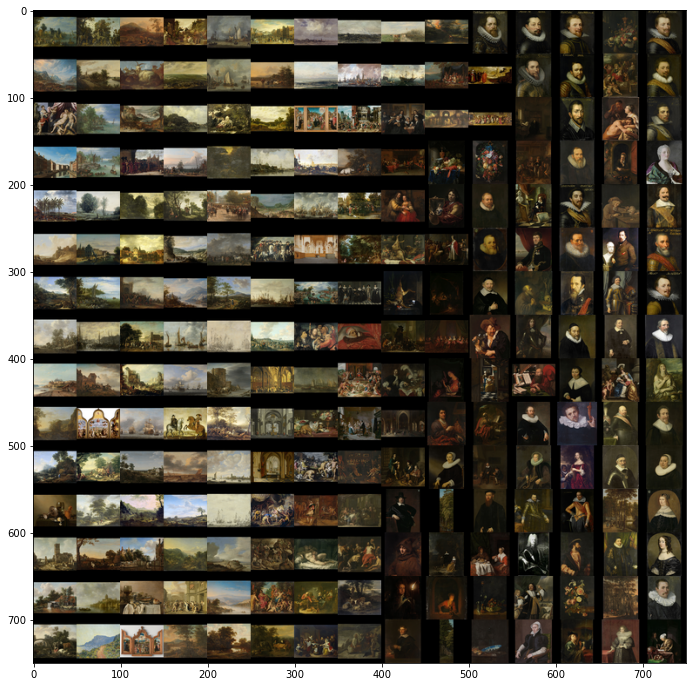

In [103]:
tile_width = 50
tile_height = 50

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

### Save the image

In [ ]:
background = Image.new("RGB", grid_image.size, (255, 255, 255))
background.paste(grid_image, mask=grid_image.split()[3]) # 3 is the alpha channel

background.save('../data/grid-umap.jpg', 'JPEG', quality=100)

### Custom shape

In [267]:
image_path = "../assets/circle.png"
tile_width = 50
tile_height = 50

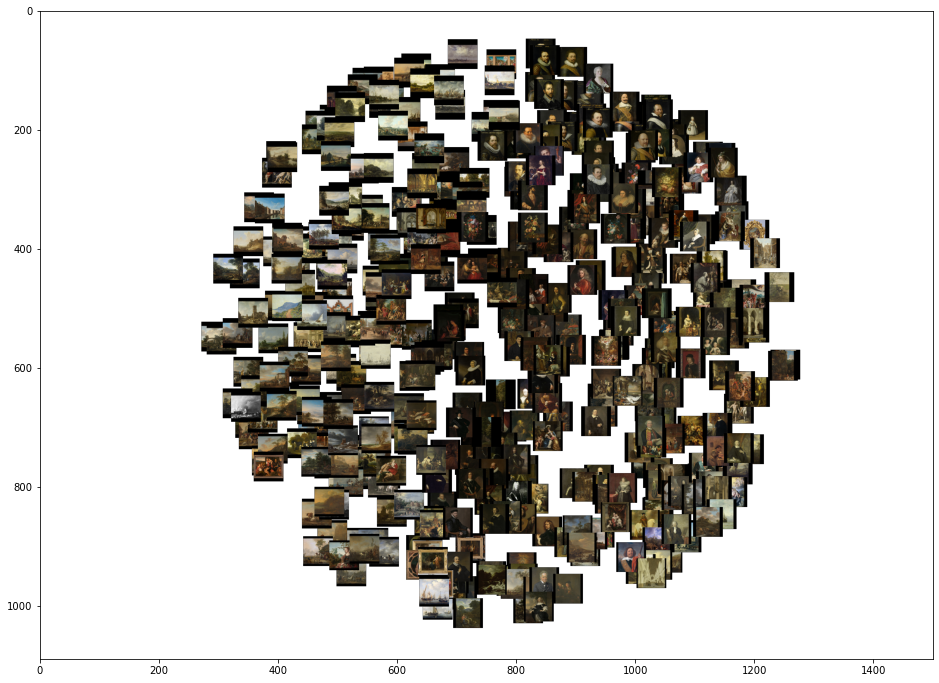

In [268]:
import PIL.Image as PImage

full_width = tile_width * 30
full_height = tile_width * 30

img = PImage.open(image_path)
wpercent = (full_width/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((full_width,hsize), Image.ANTIALIAS)

rasterMask = rasterfairy.getRasterMaskFromImage(img)
grid_xy,(width,height) = rasterfairy.transformPointCloud2D(embedding, target=rasterMask, autoAdjustCount = True)

grid_xy[:,0] += 0.5
grid_xy[:,1] += 0.5

grid_image = Image.new('RGBA', (full_width, hsize + tile_height))

for img, grid_pos in zip(images, grid_xy):
    idx_x, idx_y = grid_pos
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(idx_x), int(idx_y)))
    
matplotlib.pyplot.figure(figsize = (16,12))

imshow(grid_image)